In [30]:
import json
from typing import List, Tuple

from statistics import mean
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from rich import print
import matplotlib.pyplot as plt
from PIL import Image

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import FashionIQDataset, targetpad_transform
from src.combiner import Combiner
from src.utils import extract_index_features, device, extract_index_features_with_text_captions
from src.validate import generate_fiq_val_predictions

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Modify the function for calculation in different alpha values</div>

# <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform alpha search for the best alpha value after the search and index were encoded</div>

In [2]:
def compute_fiq_val_metrics_text_image_modified(
    relative_val_dataset: FashionIQDataset,
    blip_text_encoder: torch.nn.Module,
    multiple_text_index_features: List[torch.tensor],
    multiple_text_index_names: List[List[str]],
    image_index_features: torch.tensor,
    image_index_names: List[str],
    combining_function: callable
) -> pd.DataFrame:
    """
    Compute validation metrics on FashionIQ dataset combining text and image distances.

    :param relative_val_dataset: FashionIQ validation dataset in relative mode
    :param blip_text_encoder: BLIP model
    :param multiple_text_index_features: validation index features from text
    :param multiple_text_index_names: validation index names from text
    :param image_index_features: validation image index features
    :param image_index_names: validation image index names
    :param combining_function: function that combines features
    :return: the computed validation metrics
    """
    all_text_distances = []
    results = []
    alphas = np.arange(0, 1.05, 0.05)
    target_names = None

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                             combining_function, text_names,
                                                                             text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    # Normalize and compute distances for image features if available
    if image_index_features is not None and len(image_index_features) > 0:
        predicted_image_features, _ = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                   combining_function, image_index_names,
                                                                   image_index_features)

        # Normalize and compute distances
        image_index_features = F.normalize(image_index_features, dim=-1).float()
        image_distances = 1 - predicted_image_features @ image_index_features.T
    else:
        image_distances = torch.zeros_like(all_text_distances[0])

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    # Iterating over alpha values
    for alpha in alphas:
        merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
        sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        sorted_index_names = np.array(image_index_names if image_index_names else multiple_text_index_names[0])[sorted_indices]
        labels = torch.tensor(
            sorted_index_names == np.repeat(np.array(target_names), len(sorted_index_names[0])).reshape(len(target_names), -1))
        assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
        recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
        recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100
        results.append({"alpha": alpha, "recall_at10": recall_at10, "recall_at50": recall_at50})

    return pd.DataFrame(results)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">The only diffence is remove alpha parameter from the function</div>

In [3]:
def fashioniq_val_retrieval_text_image_modified(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable):
    """
    Perform retrieval on FashionIQ validation set computing the metrics. To combine the features the `combining_function`
    is used
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined
                            features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    """

    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()

    # Define the validation datasets and extract the index features
    classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)

    multiple_index_features, multiple_index_names = [], []

    for i in range(3):
        index_features, index_names, _ = extract_index_features_with_text_captions(
            classic_val_dataset,
            blip_text_encoder,
            text_captions,
            i + 1
        )
        multiple_index_features.append(index_features)
        multiple_index_names.append(index_names)

    image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    return compute_fiq_val_metrics_text_image_modified(
        relative_val_dataset,
        blip_text_encoder,
        multiple_index_features,
        multiple_index_names,
        image_index_features,
        image_index_names,
        combining_function
    )

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the BLIP model and the Combiner</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [4]:
BLIP_PRETRAINED_PATH = '../models/model_base.pth'
MED_CONFIG_PATH = 'blip_modules/med_config.json'
BLIP_MODEL_PATH = '../models/tuned_blip_best.pt'
COMBINER_PATH = '../models/combiner.pt'

In [5]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../models/model_base.pth for text_encoder.
load checkpoint from ../models/model_base.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [6]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH)
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder = blip_img_encoder.eval()

reshape position embedding from 196 to 576
load checkpoint from ../models/model_base.pth for visual_encoder.
load checkpoint from ../models/model_base.pth for vision_proj.


blip img encoder loaded.

In [7]:
print('Trying to load the fine-tuned BLIP model')
state_dict = torch.load(BLIP_MODEL_PATH, map_location=device)
blip_text_encoder.load_state_dict(state_dict["BLIPTextEncoder"])
print('BLIP model loaded successfully')
print(f"load epoch {state_dict['epoch']}")

Trying to load the fine-tuned BLIP model

BLIP model loaded successfully

load epoch 6

In [8]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [9]:
combiner = Combiner(256, 640 * 4, 640 * 8).to(device, non_blocking=True)
state_dict = torch.load(COMBINER_PATH, map_location=device)
combiner.load_state_dict(state_dict["Combiner"])
combiner.eval()
combining_function = combiner.combine_features

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions and perform retrieval on the FashionIQ dataset</div>

In [10]:
average_recall_list: List[pd.DataFrame] = []

with open('../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [39]:
shirt_recall = fashioniq_val_retrieval_text_image_modified(
    'shirt',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)
average_recall_list.append(shirt_recall)

shirt_recall.head()

FashionIQ val - ['shirt'] dataset in classic mode initialized


100%|██████████| 199/199 [01:08<00:00,  2.89it/s]

FashionIQ val - ['shirt'] dataset in relative mode initialized


[2024-04-27 23:04:53.428269] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 48.24it/s]


[2024-04-27 23:04:54.766897] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 48.35it/s]


[2024-04-27 23:04:56.100168] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 48.40it/s]


[2024-04-27 23:04:57.432325] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 48.40it/s]


,alpha,recall_at10,recall_at50
0,0.00,42.198235,64.082432
1,0.05,42.443573,64.720315
2,0.10,42.590776,64.867514
3,0.15,42.590776,64.376843
4,0.20,41.903827,63.591754


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [40]:
dress_recall = fashioniq_val_retrieval_text_image_modified(
    'dress',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)
average_recall_list.append(dress_recall)
dress_recall.head()

FashionIQ val - ['dress'] dataset in classic mode initialized


100%|██████████| 120/120 [00:42<00:00,  2.84it/s]

FashionIQ val - ['dress'] dataset in relative mode initialized


[2024-04-27 23:06:12.183386] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 46.03it/s]


[2024-04-27 23:06:13.581062] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 46.01it/s]


[2024-04-27 23:06:14.979783] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 46.40it/s]


[2024-04-27 23:06:16.366172] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 47.28it/s]


,alpha,recall_at10,recall_at50
0,0.00,41.497272,67.079824
1,0.05,41.695589,67.030245
2,0.10,41.150224,66.584033
3,0.15,40.158650,65.889937
4,0.20,39.712444,65.146255


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [41]:
toptee_recall = fashioniq_val_retrieval_text_image_modified(
    'toptee',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)
average_recall_list.append(toptee_recall)
toptee_recall.head()

FashionIQ val - ['toptee'] dataset in classic mode initialized


100%|██████████| 168/168 [00:56<00:00,  2.99it/s]

FashionIQ val - ['toptee'] dataset in relative mode initialized


[2024-04-27 23:07:53.254170] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 43.90it/s]


[2024-04-27 23:07:54.675831] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 48.12it/s]


[2024-04-27 23:07:55.973766] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 49.33it/s]


[2024-04-27 23:07:57.240776] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 46.48it/s]


,alpha,recall_at10,recall_at50
0,0.00,46.353900,70.219278
1,0.05,47.169811,71.188170
2,0.10,47.526771,70.576239
3,0.15,47.526771,69.454360
4,0.20,46.659866,68.740439


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories</div>

In [43]:
average_recall = pd.DataFrame(
    {
        "alpha": dress_recall["alpha"],
        "recall_at10": np.mean([shirt_recall["recall_at10"], dress_recall["recall_at10"], toptee_recall["recall_at10"]], axis=0),
        "recall_at50": np.mean([shirt_recall["recall_at50"], dress_recall["recall_at50"], toptee_recall["recall_at50"]], axis=0)
    }
)
average_recall

,alpha,recall_at10,recall_at50
0,0.00,43.349802,67.127178
1,0.05,43.769658,67.646243
2,0.10,43.755924,67.342595
3,0.15,43.425399,66.573713
4,0.20,42.758712,65.826150
5,0.25,41.704938,64.412336
6,0.30,40.377739,62.903311
7,0.35,39.045401,61.089037
8,0.40,37.297837,59.089086
9,0.45,35.334868,57.146494


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [46]:
plt.style.use('seaborn-whitegrid')

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the plot function</div>

In [54]:
def plot_recall_at10_and_50(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))
    plt.plot(df["alpha"], df["recall_at10"], label="Recall@10", marker='o')
    plt.plot(df["alpha"], df["recall_at50"], label="Recall@50", marker='o')
    plt.axvline(x=df[df["recall_at10"] == df["recall_at10"].max()]["alpha"].values[0],
                color='r', linestyle='--', label="Best Recall@10")
    plt.axvline(x=df[df["recall_at50"] == df["recall_at50"].max()]["alpha"].values[0],
                color='g', linestyle='--', label="Best Recall@50")

    plt.xlabel("Alpha")
    plt.ylabel("Recall (%)")
    plt.title(title)
    plt.legend()
    plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

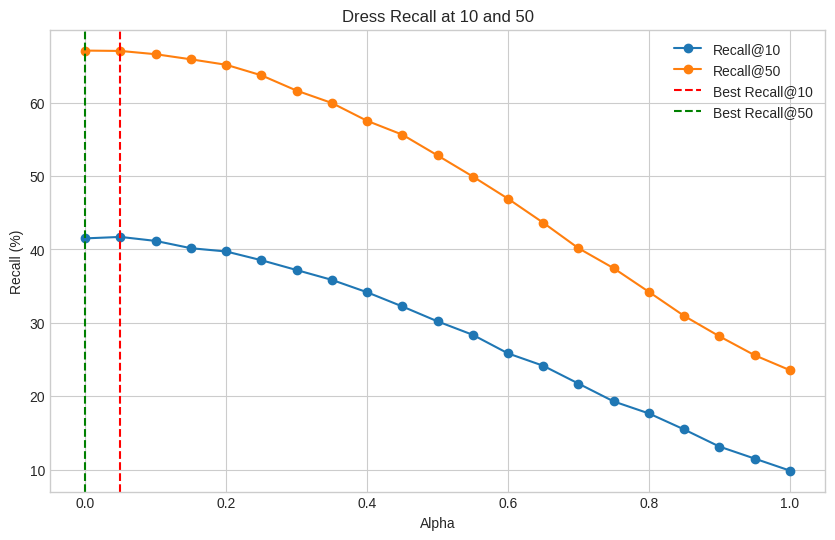

In [55]:
plot_recall_at10_and_50(dress_recall, "Dress Recall at 10 and 50")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

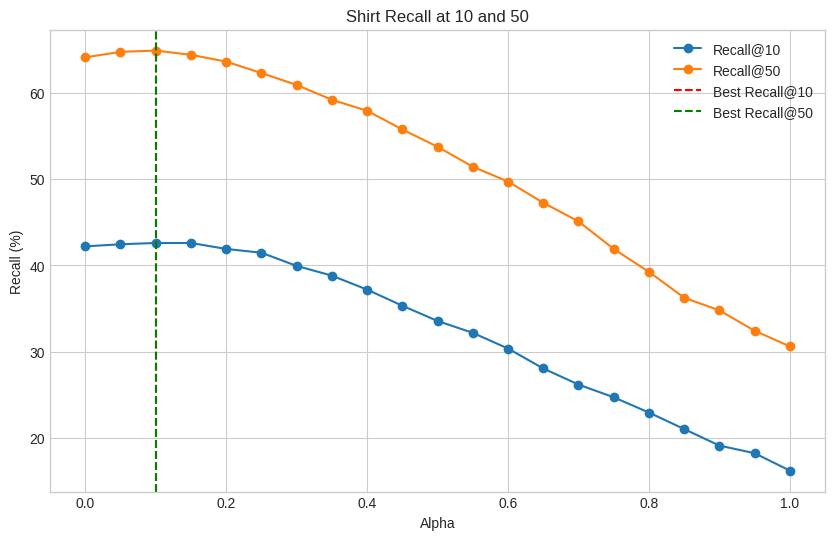

In [56]:
plot_recall_at10_and_50(shirt_recall, "Shirt Recall at 10 and 50")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

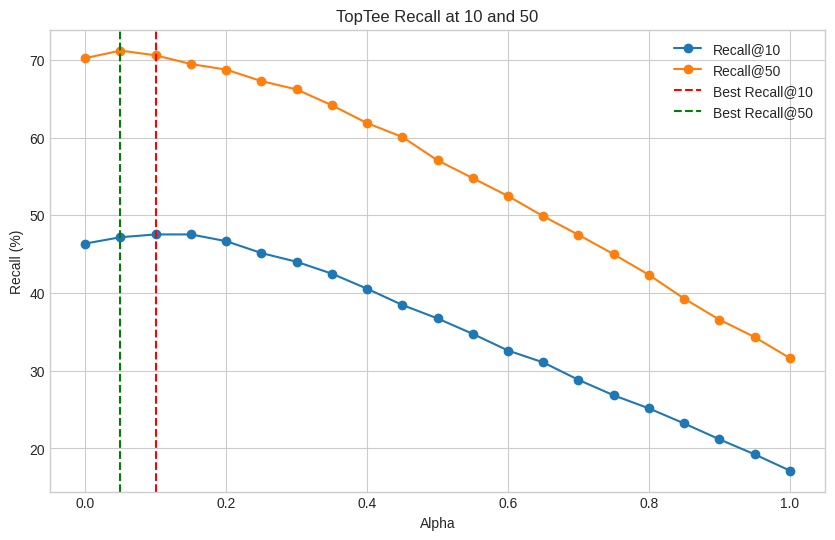

In [57]:
plot_recall_at10_and_50(toptee_recall, "TopTee Recall at 10 and 50")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

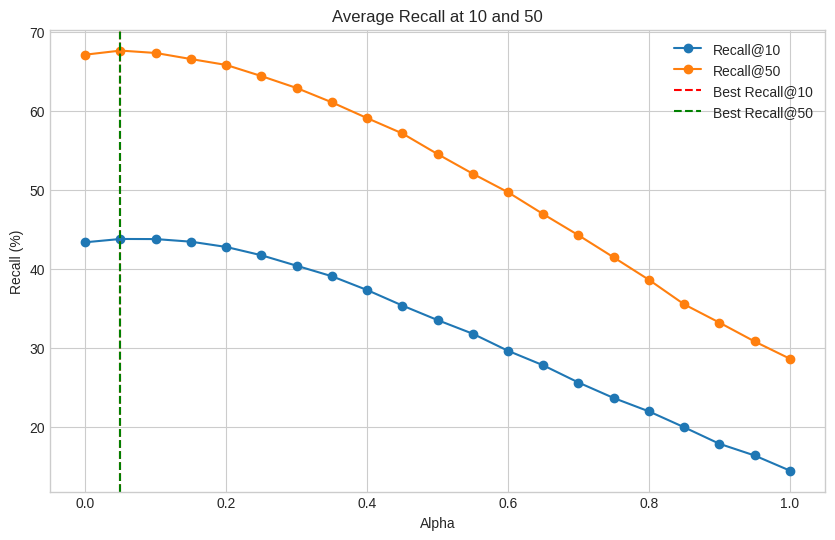

In [58]:
plot_recall_at10_and_50(average_recall, "Average Recall at 10 and 50")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to compute the results</div>

In [153]:
def compute_results(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable,
    alpha: float = 0.05
)-> Tuple[torch.tensor, List[str], List[str]]:
    """
    View sample results on FashionIQ dataset combining text and image distances.
    
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined
                            features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    :param alpha: alpha value for combining text and image distances
    
    :return: [(image_path, text_caption, candidate_image_paths)]
    """
    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()
    
    # Define the validation datasets and extract the index features
    classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)
    
    multiple_text_index_features, multiple_text_index_names = [], []
    
    for i in range(3):
        index_features, index_names, _ = extract_index_features_with_text_captions(
            classic_val_dataset,
            blip_text_encoder,
            text_captions,
            i + 1
        )
        multiple_text_index_features.append(index_features)
        multiple_text_index_names.append(index_names)
    
    image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)
    
    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)
    
    all_text_distances = []
    
    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                             combining_function, text_names,
                                                                             text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    predicted_image_features, target_names = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                               combining_function, image_index_names,
                                                               image_index_features)

    # Normalize and compute distances
    image_index_features = F.normalize(image_index_features, dim=-1).float()
    image_distances = 1 - predicted_image_features @ image_index_features.T

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)
    
    merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
    
    # Sort the results
    sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        
    return sorted_indices, image_index_names, target_names

In [160]:
sorted_indices, image_index_names, target_names = compute_results(
    'dress',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)

FashionIQ val - ['dress'] dataset in classic mode initialized


100%|██████████| 120/120 [00:34<00:00,  3.45it/s]

FashionIQ val - ['dress'] dataset in relative mode initialized


[2024-04-28 01:49:08.089505] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 53.17it/s]


[2024-04-28 01:49:09.300834] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 52.74it/s]


[2024-04-28 01:49:10.521387] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 51.54it/s]


[2024-04-28 01:49:11.769282] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 51.71it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [161]:
def prepare_ground_truths(json_data):
    """
    Prepare ground truth data from the JSON structure.
    
    :param json_data: JSON data containing target and candidate matches with captions
    :return: Dictionary mapping targets to lists of tuples (candidates and captions)
    """
    ground_truths = {}
    for entry in json_data:
        target = entry['target']
        candidate = entry['candidate']
        captions = entry['captions']
        if target not in ground_truths:
            ground_truths[target] = []
        ground_truths[target].append((candidate, captions))  # Store as a tuple
    return ground_truths

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the retrieval results for a query</div>

In [162]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image

def plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truths, top_k=5, i=0):
    """
    Plot retrieval results for a specific query showing the query and its top retrieved images, highlighting ground truths
    and displaying associated captions to the left of the query image.

    :param sorted_indices: 2D tensor or array with sorted indices of retrieved images per query.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param target_names: List of names or descriptions for each query.
    :param ground_truths: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to display per query.
    :param i: Index of the query to display.
    """
    fig = plt.figure(figsize=(30, 5))
    gs = GridSpec(1, top_k + 2, figure=fig)

    query_index = i
    query_img_path = image_index_names[query_index]
    query_img = Image.open(f'../fashionIQ_dataset/images/{query_img_path}.png')
    
    # Subplot for the caption text to the left of the query image
    ax_text = fig.add_subplot(gs[0, 0])
    query_name = target_names[query_index]
    query_captions = '\n'.join(capt for _, caps in ground_truths.get(query_name, []) for capt in caps)
    ax_text.text(0.5, 0.5, query_captions, va='center', ha='center')
    ax_text.axis('off')

    # Subplot for the query image
    ax_image = fig.add_subplot(gs[0, 1])
    ax_image.imshow(query_img)
    ax_image.set_title(f"Query: {query_name}", color='blue')
    ax_image.axis('off')

    top_indices = sorted_indices[i, :top_k]

    for j, idx in enumerate(top_indices, start=0):
        img_path = image_index_names[idx]
        img = Image.open(f'../fashionIQ_dataset/images/{img_path}.png')
        
        ax_result = fig.add_subplot(gs[0, j + 2])  # Starting from the third grid column
        ax_result.imshow(img)

        # Check if this image is a ground truth and retrieve its captions
        image_captions = '\n'.join(capt for cand, caps in ground_truths.get(query_name, []) if cand == img_path for capt in caps)
        if img_path in [cand for cand, _ in ground_truths.get(query_name, [])]:
            ax_result.set_title(f"{img_path}", color='green')
        else:
            ax_result.set_title(img_path)

        ax_result.axis('off')

    plt.tight_layout()
    plt.show()

In [163]:
ground_truth = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.dress.val.json')))

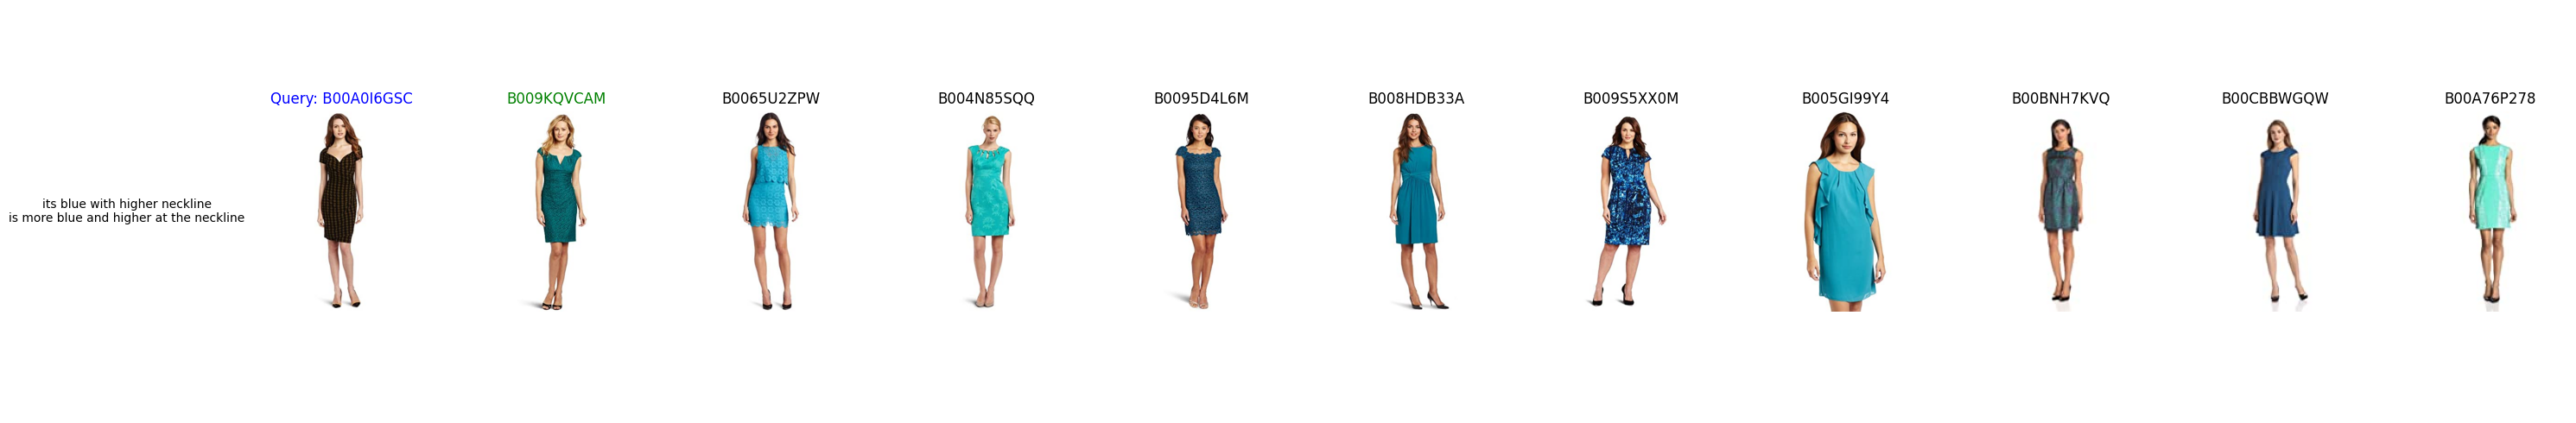

In [164]:
plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truth, top_k=10, i=10)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare to alpha=0 (Same as the original BLIP4CIR)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results with alpha=0</div>

In [165]:
sorted_indices_origin, image_index_names_origin, target_names_origin = compute_results(
    'dress',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['dress'] dataset in classic mode initialized


100%|██████████| 120/120 [00:36<00:00,  3.33it/s]

FashionIQ val - ['dress'] dataset in relative mode initialized


[2024-04-28 01:50:11.544771] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 52.42it/s]


[2024-04-28 01:50:12.772342] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 52.45it/s]


[2024-04-28 01:50:13.998824] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 53.07it/s]


[2024-04-28 01:50:15.211329] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 52.29it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results</div>

In [238]:
def found_better_than_original_i(
        sorted_indices_origin, image_index_names_origin, target_names_origin,
        sorted_indices, image_index_names, target_names, ground_truth, top_k=10
):
    """
    Return indices of queries where the new retrieval results are better than the original results.
    
    :param sorted_indices_origin: 2D array with sorted indices of retrieved images per query for the original method.
    :param image_index_names_origin: List of image paths corresponding to indices in sorted_indices_origin.
    :param target_names_origin: List of names or descriptions for each query for the original method.
    :param sorted_indices: 2D array with sorted indices of retrieved images per query for the new method.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param target_names: List of names or descriptions for each query for the new method.
    :param ground_truth: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to consider per query.
    :return: List of indices where the new method outperforms the original method.
    """
    better_indices = []
    total_queries = len(target_names_origin)  # Assuming the same number of queries for both sets

    for i in range(total_queries):
        original_rank = top_k + 1  # Initialize with a rank worse than top_k
        new_rank = top_k + 1

        # Get ground truth candidates for this query
        query_name = target_names_origin[i]
        ground_truth_candidates = [cand for cand, _ in ground_truth.get(query_name, [])]

        # Find the rank of the first ground truth candidate in the original results
        for rank, idx in enumerate(sorted_indices_origin[i, :top_k]):
            if image_index_names_origin[idx] in ground_truth_candidates:
                original_rank = rank
                break

        # Find the rank of the first ground truth candidate in the new results
        for rank, idx in enumerate(sorted_indices[i, :top_k]):
            if image_index_names[idx] in ground_truth_candidates:
                new_rank = rank
                break

        # Compare the ranks; lower is better
        if new_rank < original_rank and new_rank < top_k:
            better_indices.append(i)  # Collect index where new is better

    return better_indices

In [242]:
become_better =  found_better_than_original_i(sorted_indices_origin, image_index_names_origin, target_names_origin,
                                              sorted_indices, image_index_names, target_names, ground_truth, top_k=10)

len(become_better), become_better[:10]

(354, [13, 20, 23, 30, 31, 32, 40, 41, 59, 61])

In [243]:
become_worse =  found_better_than_original_i(sorted_indices, image_index_names, target_names,
                                             sorted_indices_origin, image_index_names_origin, target_names_origin, ground_truth, top_k=10)

len(become_worse), become_worse[:10]

(8, [302, 585, 989, 1062, 1291, 1625, 1653, 1994])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results</div>

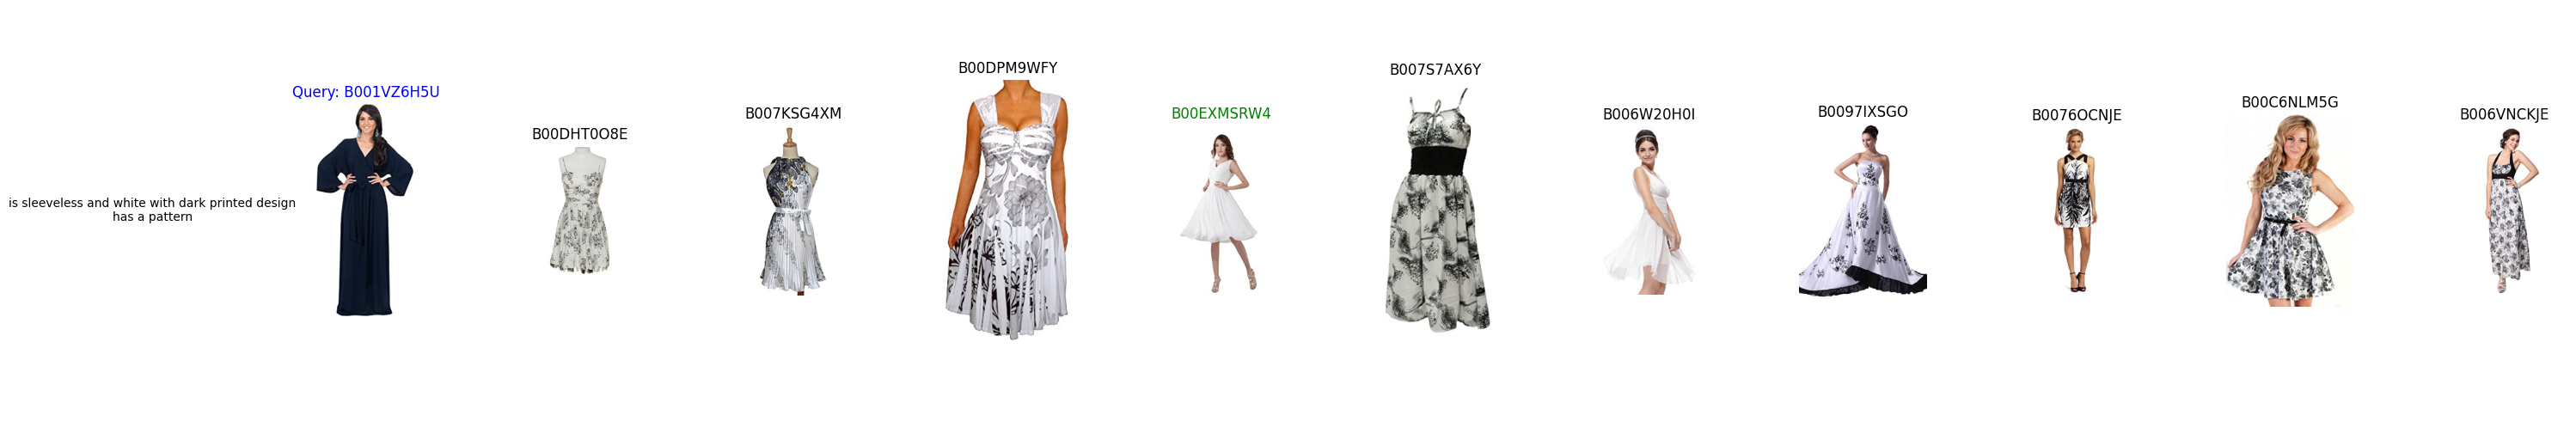

In [248]:
plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truth, top_k=10, i=32)

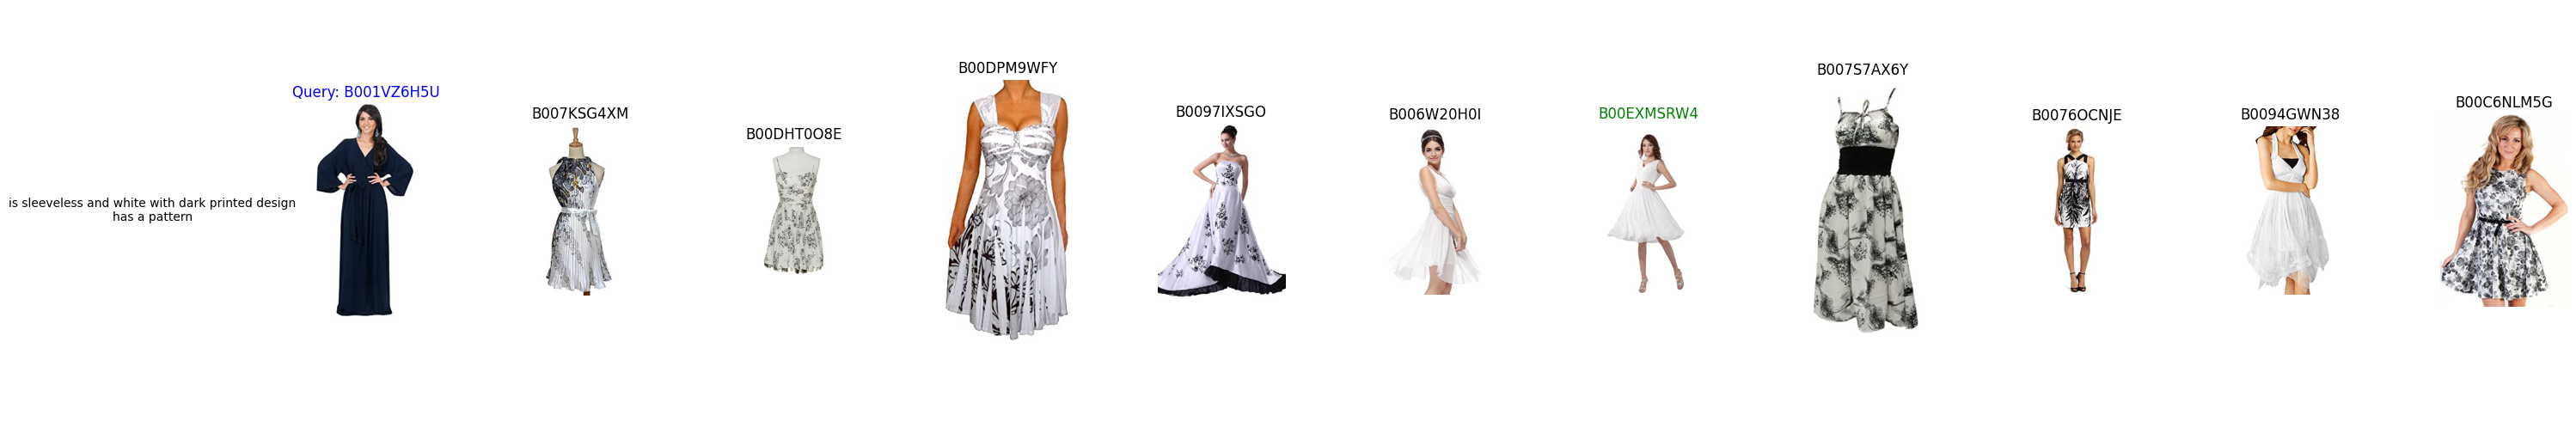

In [249]:
plot_retrieval_results_of_i(sorted_indices_origin, image_index_names_origin, target_names_origin, ground_truth, top_k=10, i=32)